<a href="https://colab.research.google.com/github/SalarShafiee/Image-classification/blob/main/Alzaymer%20aufgabe-With%20TF.Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1-First we download the dataset from Kaggle directly on Colab

In [40]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("lukechugh/best-alzheimer-mri-dataset-99-accuracy")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy/versions/1


Then we import the neccessary Libraries from Tensorflow

In [41]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model  # Corrected 'model' to 'Model'
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob  # Corrected a typo: 'glob.' to 'glob'

Our dataset does not have validation dataset, so we first define the path for Train, and Test dataset and then later will define the Validation data set.

In [42]:
train_path='/root/.cache/kagglehub/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy/versions/1/Combined Dataset/train'
test_path='/root/.cache/kagglehub/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy/versions/1/Combined Dataset/test'

Here we will define the size of input Image and the mini-batch size of which we want to call and  feed to the CNN. since they are hyper parameters, these are the metrics we would change to see the effect on Validation loss / Validation accuracy.

In [43]:
IMG_SIZE=[224,224]
BATCH_SIZE=8

We use tf.image_dataset_from_directory method, to get the images same as the image size already defined and as the batch size from respective directories and shuffle while extracting. thu shuffeling will help the model not to learn from the patterns of data ( if available).

tf.image_dataset_from_directory method, needs the folder organization to be in a specific format to recognize the label of each class and cound each photo in each class. our dataset directory already met the this condition !


As shown, we have 10240 images dedicated to 4 different classes.



In [44]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_path,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 10240 files belonging to 4 classes.


We do the same for the Train data set.

In [60]:
test_dataset = tf.keras.utils.image_dataset_from_directory(test_path,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 1279 files belonging to 4 classes.


To have an overview of the class names of our data, we call class_names method on image_dataset_from_directory

In [46]:
class_names = train_dataset.class_names
class_names

['Mild Impairment',
 'Moderate Impairment',
 'No Impairment',
 'Very Mild Impairment']

We can have also see if our training data is distrubuted evenly(balanced) between each classes. this way we can make sure our model is not trained in a biased way. otherwise we shoud implement some over/under sample or other methods of unsupervised balancing methods.

Here we can see that our data is moderatly balanced in each classes.

In [49]:
class_counts = {class_name: 0 for class_name in class_names}

for images, labels in train_dataset:
    for label in labels.numpy():
        class_counts[class_names[label]] += 1

print(class_counts)

{'Mild Impairment': 2560, 'Moderate Impairment': 2560, 'No Impairment': 2560, 'Very Mild Impairment': 2560}


this is a simple visualisation of quantity of each the data in each respective class

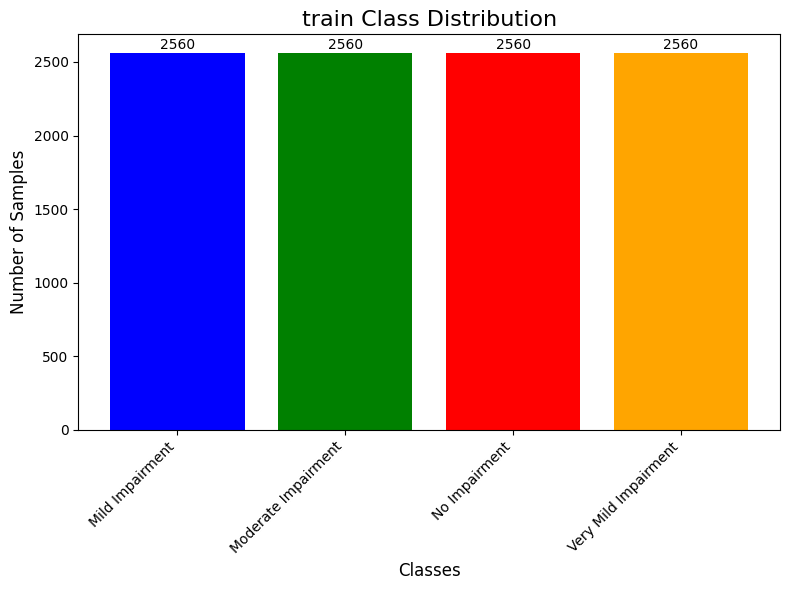

In [9]:
import matplotlib.pyplot as plt

# Assuming you have 'class_counts' dictionary from previous steps

plt.figure(figsize=(8, 6))  # Adjust figure size if needed
plt.bar(class_names, list(class_counts.values()), color=['blue', 'green', 'red', 'orange'])  # Customize colors
plt.title('train Class Distribution', fontsize=16)
plt.xlabel('Classes', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate x-axis labels if needed
plt.yticks(fontsize=10)
plt.tight_layout()  # Adjust layout for better spacing

# Add data labels (optional)
for i, count in enumerate(class_counts.values()):
    plt.text(i, count + 10, str(count), ha='center', va='bottom', fontsize=10)  # Adjust position and font size

plt.show()

Here we use Pilow library to look at at leat 1 image from each class, to be familier with the data

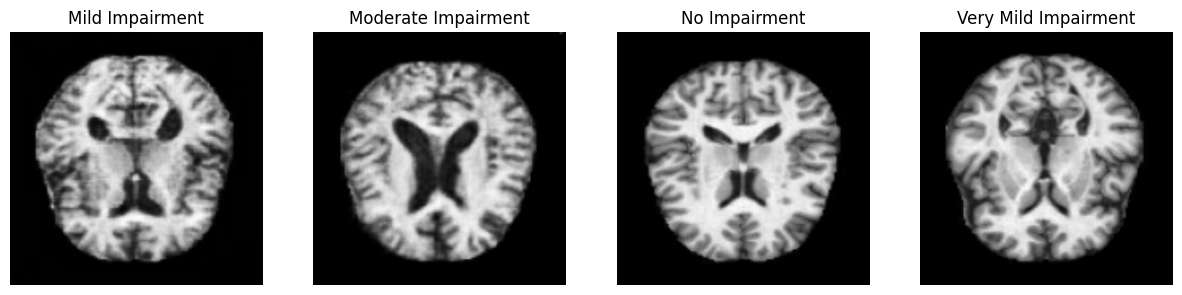

In [10]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Assuming you have 'train_dataset' and 'class_names'

# Get one sample per class
sample_images = []
sample_labels = []

for images, labels in train_dataset.take(1):
    for i in range(len(class_names)):
        index = np.where(labels.numpy() == i)[0]
        if len(index) > 0:
            sample_images.append(images[index[0]].numpy())
            sample_labels.append(class_names[i])

# Display images using Pillow and Matplotlib
fig, axs = plt.subplots(1, len(class_names), figsize=(15, 5))  # Adjust figsize as needed

for i, (image, label) in enumerate(zip(sample_images, sample_labels)):
    img = Image.fromarray(image.astype("uint8"))  # Convert to PIL Image
    axs[i].imshow(img)
    axs[i].set_title(label)
    axs[i].axis('off')

plt.show()

As we saw above we do not have Validation batch, so in the following code we will make it. first with Cardinality method, we see on the Train data quantity and with the given bach number, how many sets of batches do we have?

In [11]:
val_batches = tf.data.experimental.cardinality(train_dataset)
val_batches


<tf.Tensor: shape=(), dtype=int64, numpy=1280>

then with the following code, we get 80% of the training data for tarining. and take 20% of them to the validation_dataset.

In [12]:

valid_dataset = train_dataset.take(val_batches // 5)
train_dataset = train_dataset.skip(val_batches // 5)

In [13]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(valid_dataset))
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))

Number of validation batches: 256
Number of train batches: 1024


Use buffered prefetching to load images from disk without having I/O become blocking.

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
Valid_dataset = valid_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

this is the Augmentation layer, in order to make sure our model is more robust and does not overfit.

We have implemented one flip, rotation and random zoom to each batch of image.

We defined the augmentation as a layer, which then we will pass it to our model.

In [15]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),  # Flip both ways
    tf.keras.layers.RandomRotation(0.3, fill_mode='nearest'),  # Increased rotation
    tf.keras.layers.RandomZoom(height_factor=(-0.2, 0.3), width_factor=(-0.2,0.3), fill_mode='nearest'), # Add zooming

])

we have 10240 train image data. So, it is not that much big data to train from scratch, also it is not low that much to use just the weights from a pretrained model( specifically because it it a medical image).

So, we use transfer learning, but then we will fine-tune the model later to learn the latest layer with some specific features from our own dedicated data.

In [16]:
from tensorflow.keras.applications import Xception  # Choose a scale (e.g., B4)
from tensorflow.keras.applications.xception import preprocess_input # Corrected import

We will pass the shape structure of the image which is expected by the model.

Then we will say to the model to call and download the pretrained weight wich was trained on 'imagenet' dataset.

In [17]:
IMG_SHAPE = IMG_SIZE + [3]
base_model = Xception(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


As said above, we want to fine-tune the model to learn from our ouw dedicated data. So, I have unfreezed last 7 layers of the pretraind data to learn from my data and get more specific features.

Note: While fine tuning I should make sure the base starting learning rate in not high, and also When i unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, I should keep the BatchNormalization layers in inference mode by passing training = False when calling the base model.

In [18]:

for layer in base_model.layers[:-7]:
    layer.trainable = True  # Make sure they are trainable


I get a summary from the base model to seee the structure of the pretrained model.

In [19]:
base_model.summary()

Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 111, 111, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 111, 111, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 111, 111, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 109, 109, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 109, 109, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 109, 109, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 109, 109, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 109, 109, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 109, 109, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 55, 55, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 55, 55, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization  

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

in Next three blocks, I will call one bacth and pass to the model, to see th output shape of the layers.

In [20]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(8, 7, 7, 2048)


In [21]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(8, 2048)


In [22]:
prediction_layer = tf.keras.layers.Dense(4)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(8, 4)


In [23]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(2048, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)  # Additional Dense layer
x = tf.keras.layers.Dropout(0.4)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [24]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau



early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor (e.g., 'val_loss' or 'val_accuracy')
    patience=3,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True )  # Restore model weights from the epoch with the best value of the monitored metric)

# Define the checkpoint
checkpoint = ModelCheckpoint('best_model.keras',  # Changed file extension
                             monitor='val_loss',
                             save_best_only=True,
                             mode='min',
                             verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',  # Metric to monitor
                              factor=0.2,  # Factor by which to reduce the learning rate
                              patience=2,  # Number of epochs with no improvement after which to reduce LR
                              min_lr=0.000000001,  # Lower bound on the learning rate
                              verbose=1)  # Print a message when LR is reduced


In [25]:
base_learning_rate=0.00001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [26]:
# Fit the model with the callbacks
history = model.fit(train_dataset,
                    validation_data=valid_dataset,
                    epochs=50,
                    callbacks=[checkpoint, early_stopping, reduce_lr]) # Add to callbacks

Epoch 1/50
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 8.6780 - sparse_categorical_accuracy: 0.4218
Epoch 1: val_loss improved from inf to 6.27692, saving model to best_model.keras
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 99s 68ms/step - loss: 8.6772 - sparse_categorical_accuracy: 0.4220 - val_loss: 6.2769 - val_sparse_categorical_accuracy: 0.7300 - learning_rate: 1.0000e-05
Epoch 2/50
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 5.9546 - sparse_categorical_accuracy: 0.6889
Epoch 2: val_loss improved from 6.27692 to 4.66928, saving model to best_model.keras
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 68s 67ms/step - loss: 5.9542 - sparse_categorical_accuracy: 0.6889 - val_loss: 4.6693 - val_sparse_categorical_accuracy: 0.7725 - learning_rate: 1.0000e-05
Epoch 3/50
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 4.4914 - sparse_categorical_accuracy: 0.7190
Epoch 3: val_loss improved from 4.66928 to 3.65230, saving model to best_model.keras
1024/1024 ━━━━━━━━━━━━━━━━━━━━ 68s 67ms/step - loss

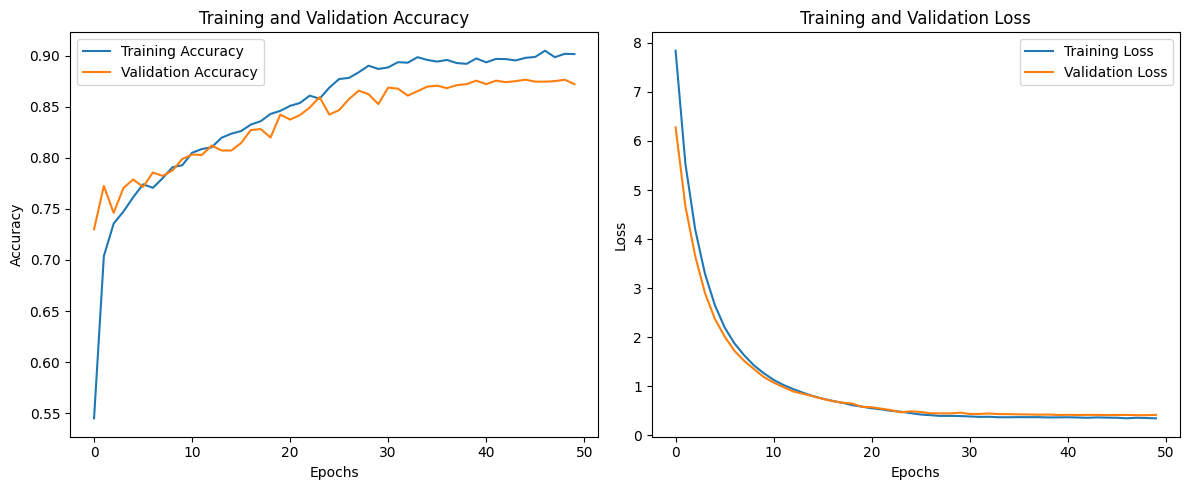

In [27]:
import matplotlib.pyplot as plt

# Extract metrics
history_dict = history.history

# Plot training and validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_dict['sparse_categorical_accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


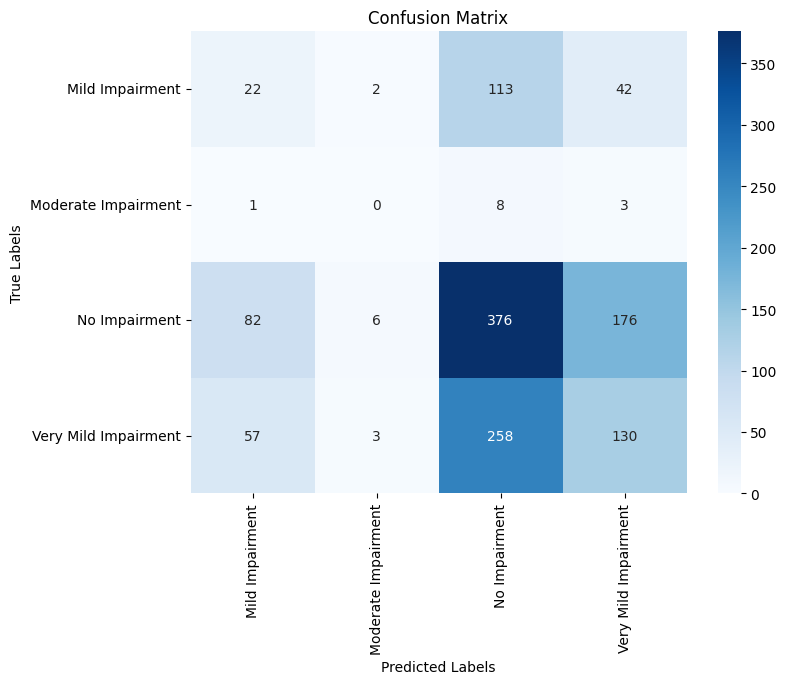

In [61]:
#def preprocess_test_image(image, label):
   # image = preprocess_input(image)
# prompt: give me the confution matrix on predicted and labed test data set on this data

import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'model' and 'test_dataset' are defined from the previous code

# Predict on the test dataset
predictions = model.predict(test_dataset)
predicted_labels = np.argmax(predictions, axis=1)

# Extract true labels from the test dataset
true_labels = []
for images, labels in test_dataset:
    true_labels.extend(labels.numpy())
true_labels = np.array(true_labels)

# Calculate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()